##  Segmentation et Polygonisation de Bâtiments




****Dataset INRIA Aerial Image Labeling****

# PARTIE 1 - IMPORTATIONS & SETUP

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from glob import glob

# PARTIE 2 - CHARGEMENT DES DONNEES


In [14]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/dataset/INRIA_Extracted/AerialImageDataset"
train_images_dir = os.path.join(data_dir, 'train', 'images')
train_masks_dir = os.path.join(data_dir, 'train', 'gt')
test_images_dir = os.path.join(data_dir, 'test', 'images')

print("Nb images train :", len(os.listdir(train_images_dir)))
print("Nb masques train:", len(os.listdir(train_masks_dir)))
print("Nb images test  :", len(os.listdir(test_images_dir)))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nb images train : 180
Nb masques train: 180
Nb images test  : 180


# PARTIE 3 - VISUALISATION DU DATASET BRUT

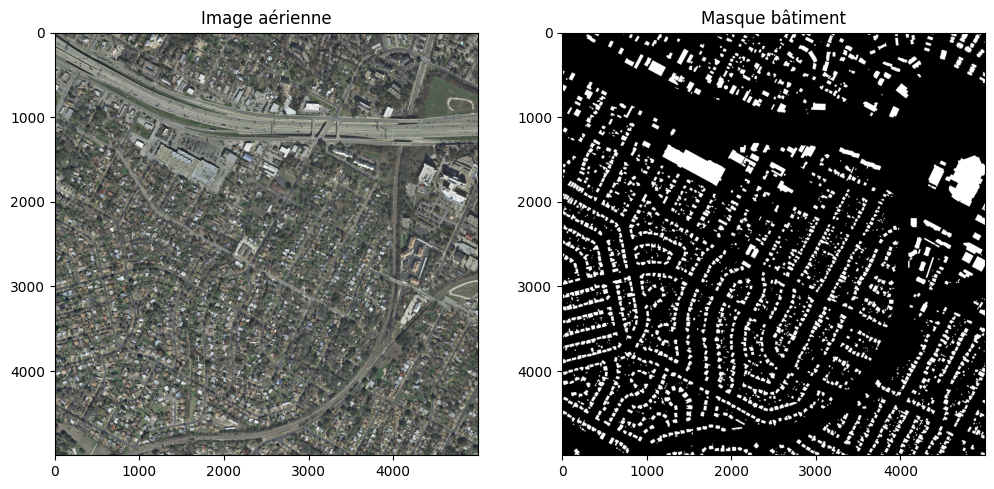

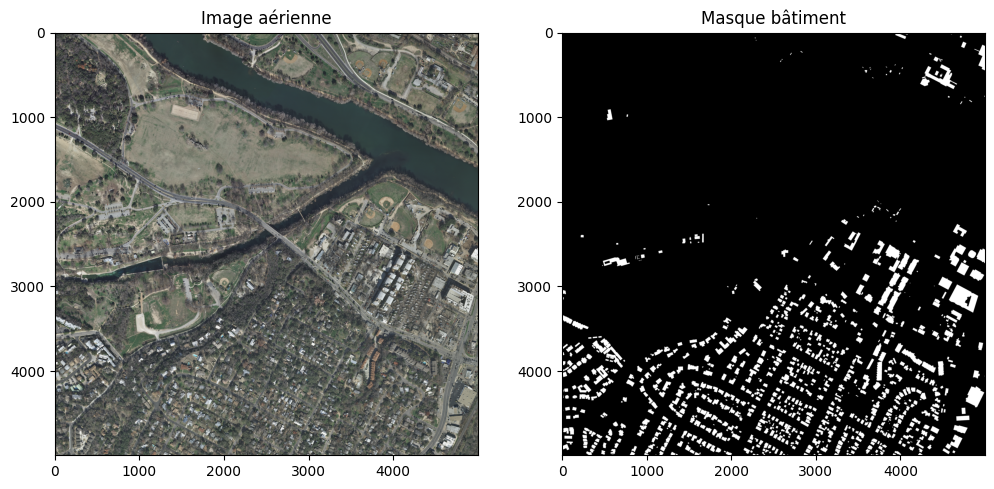

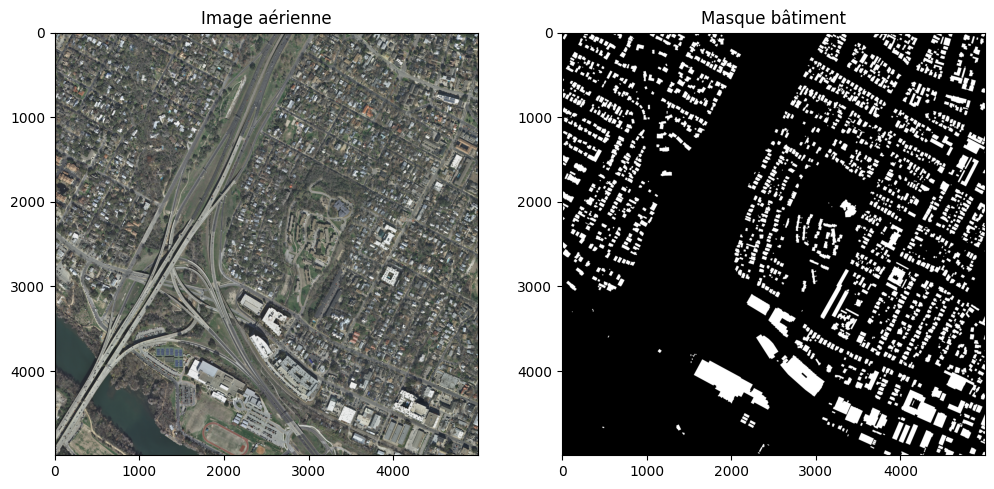

In [16]:
from PIL import Image
def plot_image_mask(image_path, mask_path):
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(image)
    axs[0].set_title("Image aérienne")
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Masque bâtiment")
    plt.show()

img_files = sorted(glob(train_images_dir + "/*.tif"))
mask_files = sorted(glob(train_masks_dir + "/*.tif"))
for i in range(3):
    plot_image_mask(img_files[i], mask_files[i])


# PARTIE 4 - PATCHING

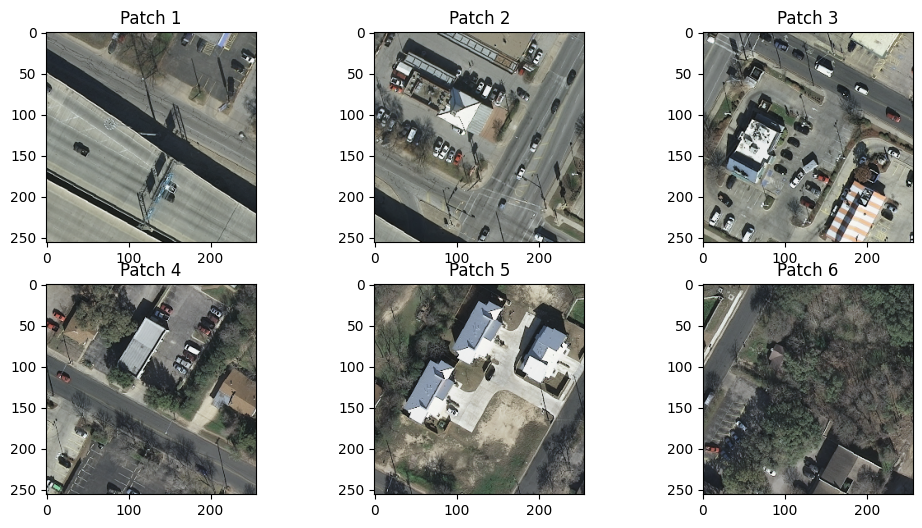

In [17]:
PATCH_SIZE = 256

def extract_patches(img, patch_size):
    patches = []
    h, w = img.shape[:2]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return patches

sample_img = np.array(Image.open(img_files[0]))
patches = extract_patches(sample_img, PATCH_SIZE)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(patches[i])
    plt.title(f"Patch {i+1}")
plt.show()


# PARTIE 5 - EXTRACTION DES PATCHES POUR TOUT LE JEU DE DONNÉES

In [18]:
def generate_all_patches(img_files, mask_files, patch_size):
    img_patches, mask_patches = [], []
    for img_path, mask_path in zip(img_files, mask_files):
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        img_patches.extend(extract_patches(img, patch_size))
        mask_patches.extend(extract_patches(mask, patch_size))
    return np.array(img_patches), np.array(mask_patches)

img_patches, mask_patches = generate_all_patches(img_files, mask_files, PATCH_SIZE)

print("Total patches extraits :", len(img_patches))


Total patches extraits : 64980


# PARTIE 6 - FILTRAGE DES PATCHES VIDES

In [19]:
def filter_empty_patches(imgs, masks, threshold=0.01):
    kept_imgs, kept_masks = [], []
    for img, mask in zip(imgs, masks):
        if np.sum(mask > 0) / (mask.size) > threshold:
            kept_imgs.append(img)
            kept_masks.append(mask)
    return np.array(kept_imgs), np.array(kept_masks)

filtered_imgs, filtered_masks = filter_empty_patches(img_patches, mask_patches)
print("Nb patches conservés après filtrage :", len(filtered_imgs))


Nb patches conservés après filtrage : 42547


# PARTIE 7 - SPLIT TRAIN / VALIDATION

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    filtered_imgs, filtered_masks, test_size=0.2, random_state=42
)

print("Train :", len(X_train), "| Val :", len(X_val))


Train : 34037 | Val : 8510


#  PARTIE 8 - DATA GENERATOR AVEC AUGMENTATION VISUALISABLE

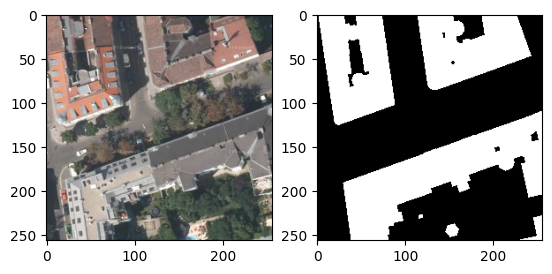

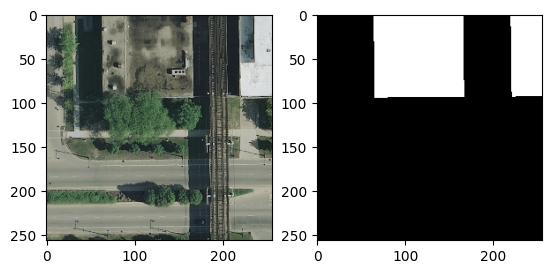

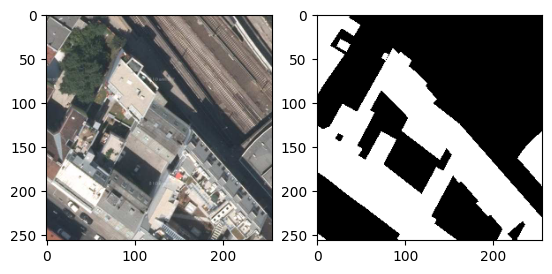

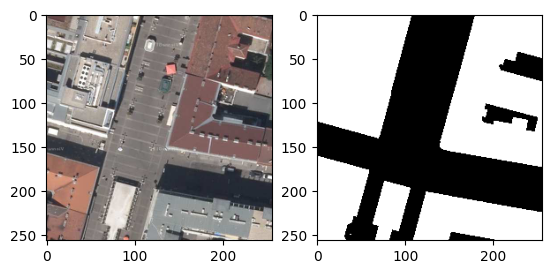

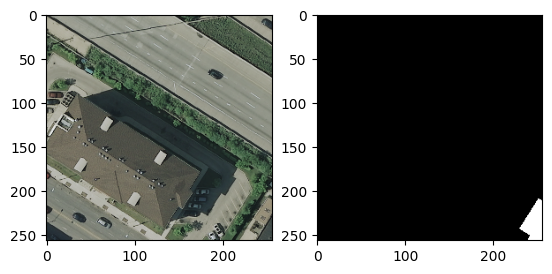

In [22]:
from tensorflow.keras.utils import Sequence

def augment(img, mask):
    if np.random.rand() > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)
    return img, mask

class PatchGenerator(Sequence):
    def __init__(self, images, masks, batch_size=32, augment=False):
        self.images, self.masks = images, masks
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx+1)*self.batch_size]
        batch_imgs, batch_masks = [], []
        for i in inds:
            img, mask = self.images[i]/255.0, self.masks[i]/255.0
            if self.augment:
                img, mask = augment(img, mask)
            batch_imgs.append(img.astype(np.float32))
            batch_masks.append(mask[..., np.newaxis].astype(np.float32))
        return np.array(batch_imgs), np.array(batch_masks)

for i in range(5):
    img, mask = augment(X_train[i], y_train[i])
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(img)
    axs[1].imshow(mask, cmap='gray')
    plt.show()


# PARTIE 9 - MODELE U-NET

In [23]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

# PARTIE 10 - FONCTIONS DE PERTE ET METRIQUES

In [24]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])


# PARTIE 11 - ENTRAINEMENT

In [25]:
batch_size = 16
epochs = 50

train_gen = PatchGenerator(X_train, y_train, batch_size=batch_size, augment=True)
val_gen = PatchGenerator(X_val, y_val, batch_size=batch_size)

earlystop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("unet_inria_best.h5", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[earlystop, checkpoint]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - dice_coef: 0.5063 - loss: 0.9366

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 90s 36ms/step - dice_coef: 0.5064 - loss: 0.9364 - val_dice_coef: 0.7186 - val_loss: 0.5725
Epoch 2/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coef: 0.7158 - loss: 0.5777

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - dice_coef: 0.7158 - loss: 0.5777 - val_dice_coef: 0.7347 - val_loss: 0.5355
Epoch 3/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coef: 0.7470 - loss: 0.5165

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.7471 - loss: 0.5165 - val_dice_coef: 0.7683 - val_loss: 0.4935
Epoch 4/50
2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - dice_coef: 0.7637 - loss: 0.4859

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 68s 32ms/step - dice_coef: 0.7637 - loss: 0.4859 - val_dice_coef: 0.7861 - val_loss: 0.4626
Epoch 5/50
2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.7716 - loss: 0.4693

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - dice_coef: 0.7716 - loss: 0.4693 - val_dice_coef: 0.7819 - val_loss: 0.4361
Epoch 6/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.7816 - loss: 0.4505 - val_dice_coef: 0.7801 - val_loss: 0.4487
Epoch 7/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - dice_coef: 0.7861 - loss: 0.4417 - val_dice_coef: 0.7939 - val_loss: 0.4466
Epoch 8/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - dice_coef: 0.7920 - loss: 0.4283 - val_dice_coef: 0.7837 - val_loss: 0.4383
Epoch 9/50
2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coef: 0.7959 - loss: 0.4220

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - dice_coef: 0.7959 - loss: 0.4220 - val_dice_coef: 0.7858 - val_loss: 0.4351
Epoch 10/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.7989 - loss: 0.4156

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - dice_coef: 0.7989 - loss: 0.4156 - val_dice_coef: 0.8045 - val_loss: 0.4161
Epoch 11/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coef: 0.8027 - loss: 0.4077

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - dice_coef: 0.8027 - loss: 0.4077 - val_dice_coef: 0.8084 - val_loss: 0.4135
Epoch 12/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.8043 - loss: 0.4053

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 68s 32ms/step - dice_coef: 0.8043 - loss: 0.4053 - val_dice_coef: 0.8039 - val_loss: 0.4097
Epoch 13/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.8070 - loss: 0.3997

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.8070 - loss: 0.3997 - val_dice_coef: 0.8054 - val_loss: 0.4046
Epoch 14/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.8090 - loss: 0.3950

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.8090 - loss: 0.3950 - val_dice_coef: 0.8096 - val_loss: 0.4037
Epoch 15/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - dice_coef: 0.8108 - loss: 0.3933 - val_dice_coef: 0.7921 - val_loss: 0.4220
Epoch 16/50
2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.8132 - loss: 0.3868

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 65s 30ms/step - dice_coef: 0.8132 - loss: 0.3868 - val_dice_coef: 0.8056 - val_loss: 0.3934
Epoch 17/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - dice_coef: 0.8133 - loss: 0.3874 - val_dice_coef: 0.8087 - val_loss: 0.4045
Epoch 18/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - dice_coef: 0.8157 - loss: 0.3820

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 71s 33ms/step - dice_coef: 0.8157 - loss: 0.3820 - val_dice_coef: 0.8157 - val_loss: 0.3888
Epoch 19/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - dice_coef: 0.8172 - loss: 0.3796 - val_dice_coef: 0.8039 - val_loss: 0.3982
Epoch 20/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - dice_coef: 0.8187 - loss: 0.3761 - val_dice_coef: 0.8024 - val_loss: 0.4013
Epoch 21/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - dice_coef: 0.8191 - loss: 0.3750

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 71s 33ms/step - dice_coef: 0.8191 - loss: 0.3750 - val_dice_coef: 0.8160 - val_loss: 0.3831
Epoch 22/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - dice_coef: 0.8232 - loss: 0.3681 - val_dice_coef: 0.8075 - val_loss: 0.3836
Epoch 23/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - dice_coef: 0.8220 - loss: 0.3698 - val_dice_coef: 0.8115 - val_loss: 0.3847
Epoch 24/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 74s 35ms/step - dice_coef: 0.8236 - loss: 0.3666 - val_dice_coef: 0.8111 - val_loss: 0.4054
Epoch 25/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 71s 33ms/step - dice_coef: 0.8232 - loss: 0.3679 - val_dice_coef: 0.8200 - val_loss: 0.3883
Epoch 26/50
2127/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - dice_coef: 0.8274 - loss: 0.3593

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - dice_coef: 0.8274 - loss: 0.3593 - val_dice_coef: 0.8152 - val_loss: 0.3754
Epoch 27/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.8268 - loss: 0.3608 - val_dice_coef: 0.8239 - val_loss: 0.3829
Epoch 28/50
2126/2128 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dice_coef: 0.8273 - loss: 0.3595

2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.8273 - loss: 0.3595 - val_dice_coef: 0.8214 - val_loss: 0.3718
Epoch 29/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - dice_coef: 0.8286 - loss: 0.3570 - val_dice_coef: 0.8214 - val_loss: 0.3762
Epoch 30/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - dice_coef: 0.8300 - loss: 0.3549 - val_dice_coef: 0.8206 - val_loss: 0.3775
Epoch 31/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 66s 31ms/step - dice_coef: 0.8288 - loss: 0.3563 - val_dice_coef: 0.8167 - val_loss: 0.3886
Epoch 32/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 65s 31ms/step - dice_coef: 0.8318 - loss: 0.3507 - val_dice_coef: 0.8248 - val_loss: 0.3740
Epoch 33/50
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - dice_coef: 0.8303 - loss: 0.3536 - val_dice_coef: 0.8261 - val_loss: 0.3719


In [30]:
#Enregistrer le modèle
model.save("mon_modele_unet_final.keras")

# Sauvegarde sur Google Drive
model.save("/content/drive/MyDrive/mon_modele_unet_final.keras")


# PARTIE 12 - COURBE D'APPRENTISSAGE

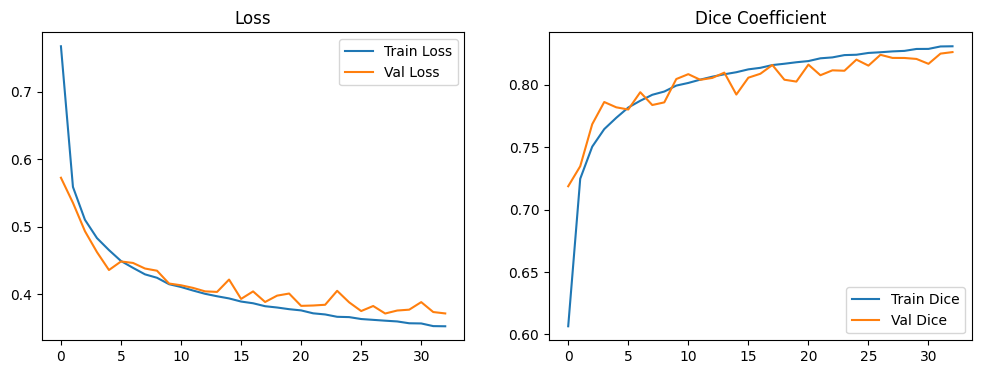

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')
plt.show()


# PARTIE 13 - VISUALISATION DES PREDICTIONS

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


532/532 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


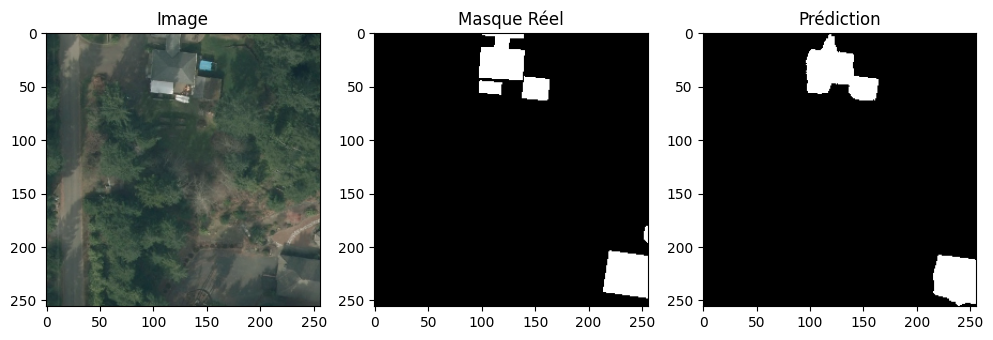

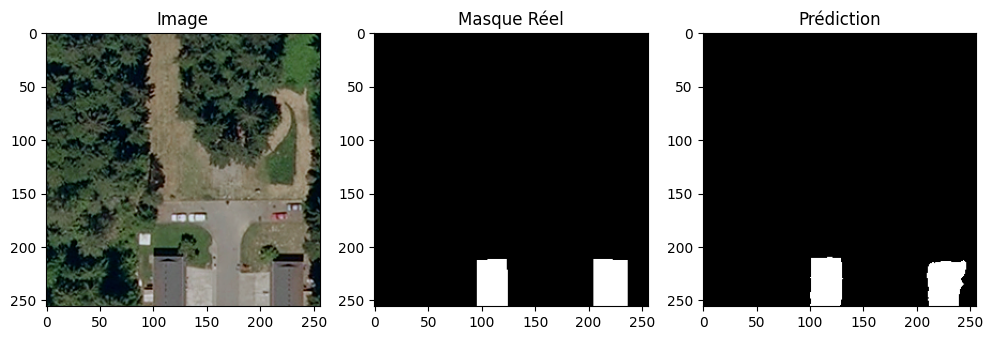

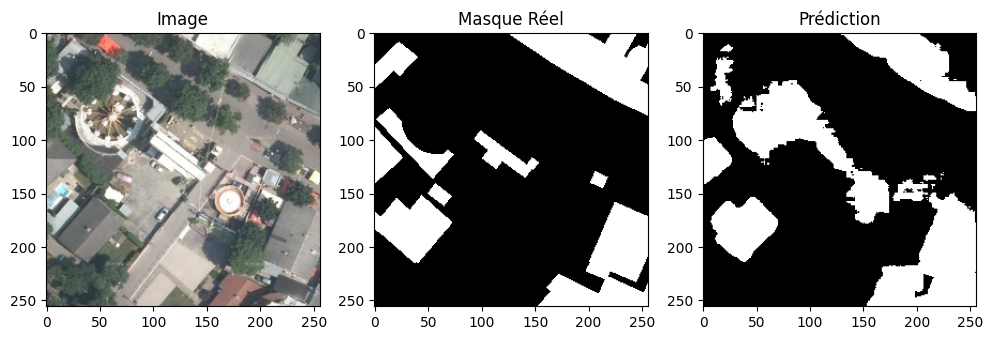

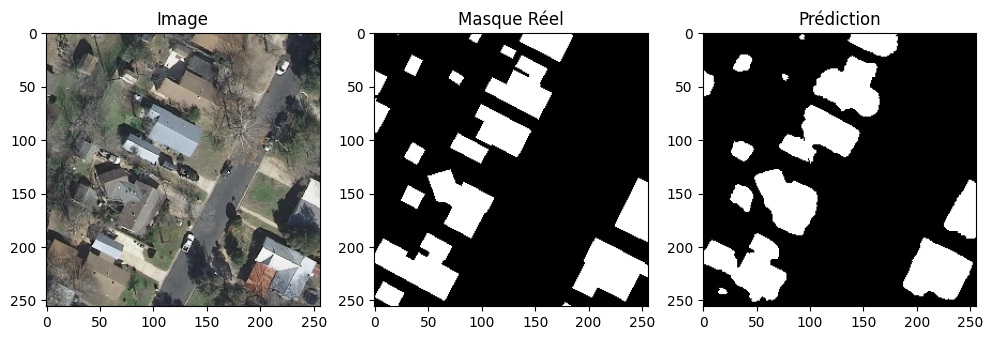

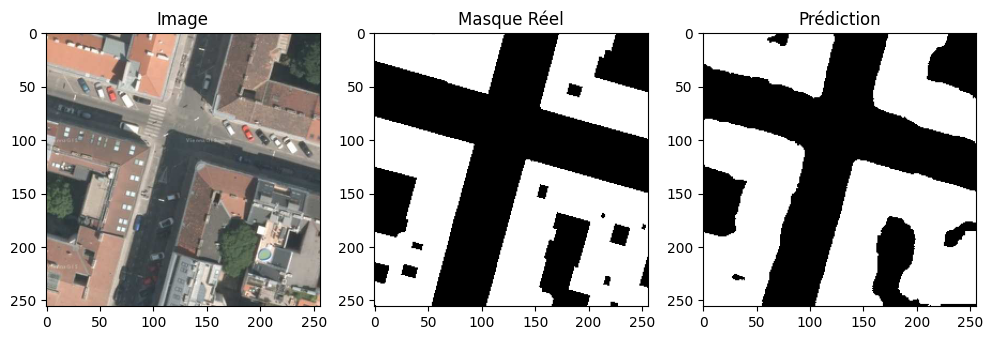

In [27]:
preds = model.predict(val_gen)

for i in range(5):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(X_val[i]/255.0)
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(y_val[i], cmap='gray')
    plt.title("Masque Réel")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title("Prédiction")

    plt.show()


# PARTIE 14 - POLYGONISATION

In [38]:
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt


def mask_to_polygons(mask, min_area=100):
    contours = measure.find_contours(mask, 0.5)
    polygons = []
    for contour in contours:
        contour = np.flip(contour, axis=1)
        poly = Polygon(contour)
        if poly.area > min_area and poly.is_valid:
            polygons.append(poly)
    return MultiPolygon(polygons)


def plot_polygons(images, masks, preds, n=5):
    for i in range(n):
        pred_mask = preds[i].squeeze() > 0.5
        polygons = mask_to_polygons(pred_mask)

        plt.figure(figsize=(8, 8))
        plt.imshow(images[i]/255.0)

        if polygons.is_empty:
            plt.title(f"Polygonisation image {i+1} (aucun polygone)")
            plt.show()
            continue
        if isinstance(polygons, Polygon):
            poly_list = [polygons]
        else:
            poly_list = list(polygons.geoms)

        for poly in poly_list:
            if poly.is_empty:
                continue
            x, y = poly.exterior.xy
            plt.plot(x, y, color='red', linewidth=1)

        plt.title(f"Polygonisation image {i+1}")
        plt.show()





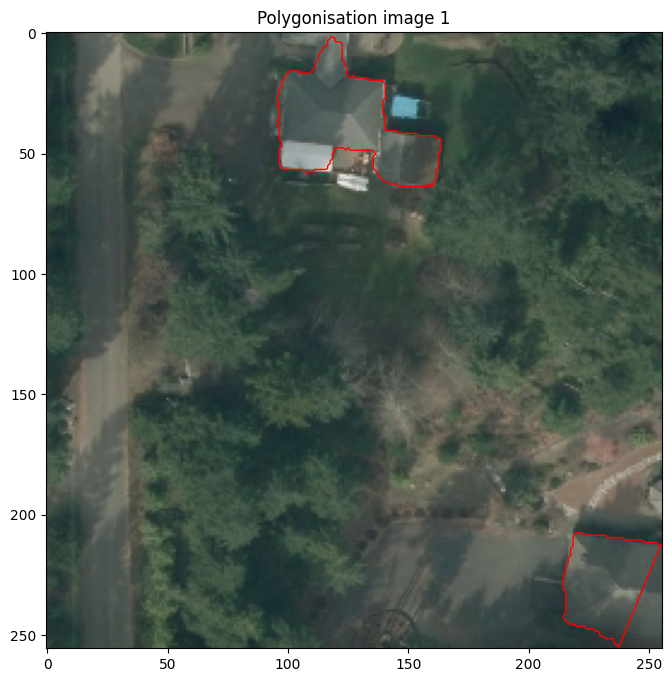

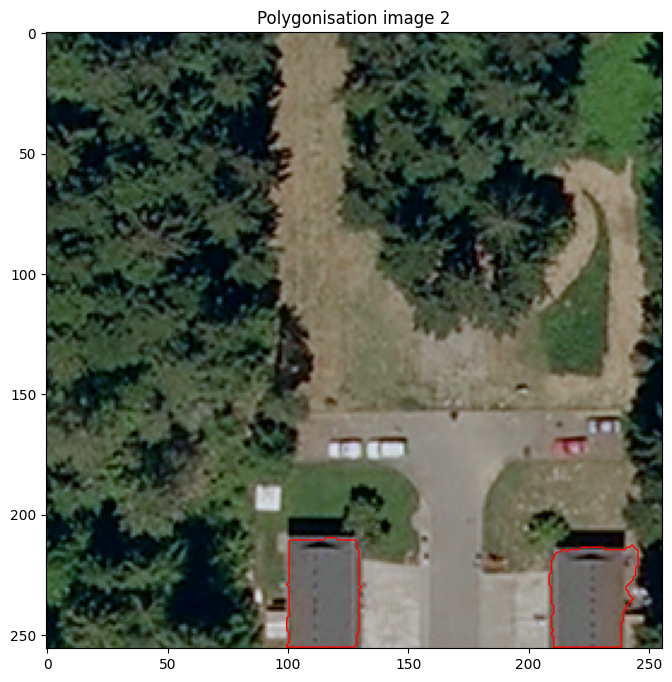

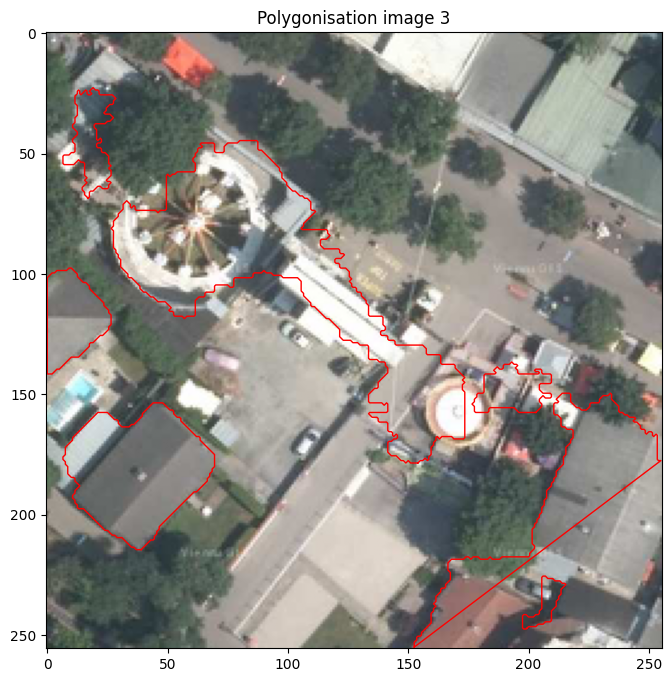

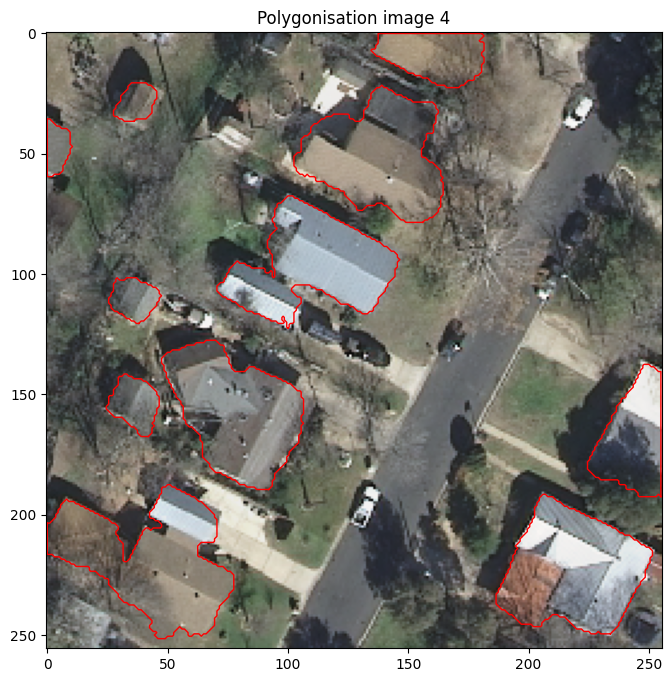

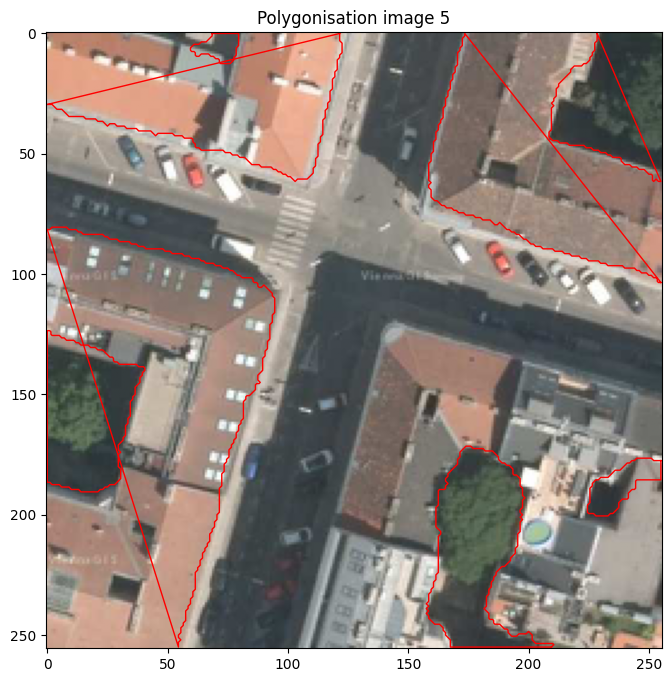

In [39]:
plot_polygons(X_val, y_val, preds, n=5)